In [1]:
import os
import sys
import datetime
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data_utils
import torchvision.transforms as transforms

sys.path.insert(0, "..")
import src.models.scanAutoencoder360 as scanAutoencoder

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
log_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/log/"
dir_list = [d for d in os.listdir(log_dir) if d.find("2023") != -1]
scans_list = [np.load(log_dir + d + "/scans.npy") for d in dir_list]
scans_list[0].shape

(101, 5, 360)

In [4]:
scans = np.concatenate(scans_list, axis = 0)

scans = torch.concatenate([scanAutoencoder.transform_scan(s) for s in scans_list], axis=0).to(device)

scans.shape

torch.Size([63970, 360])

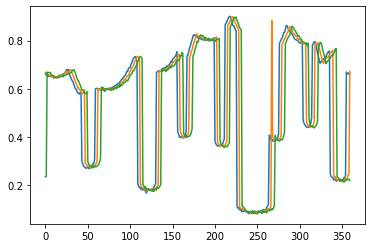

In [5]:
plt.plot(scans[5].cpu())
plt.plot(scans[6].cpu())
plt.plot(scans[7].cpu())
plt.show()

In [6]:
train_data, test_data = train_test_split(scans, test_size=0.2, shuffle=True)

train_dataset = data_utils.TensorDataset(train_data)
test_dataset = data_utils.TensorDataset(test_data)

train_data_loader = data_utils.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_data_loader = data_utils.DataLoader(test_dataset, batch_size=128, shuffle=True)

print(train_data.shape)
print(test_data.shape)

torch.Size([51176, 360])
torch.Size([12794, 360])


In [7]:
autoencoder = scanAutoencoder.Autoencoder().to(device)

cirterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)

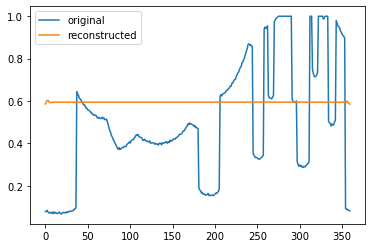

In [8]:
def plot_result(model, test_data, index = -1):
    if index == -1:
      index = np.random.randint(len(test_data))

    with torch.no_grad():
        result = model(test_data[index])

    plt.plot(test_data[index].cpu().squeeze(), label="original")
    plt.plot(result[0].cpu().squeeze(), label="reconstructed")

    plt.legend()
    plt.show()

plot_result(autoencoder, test_data)

Epoch [1/100], Step [50/400], Loss: 0.103171
Epoch [1/100], Step [100/400], Loss: 0.091742
Epoch [1/100], Step [150/400], Loss: 0.095701
Epoch [1/100], Step [200/400], Loss: 0.087748
Epoch [1/100], Step [250/400], Loss: 0.074039
Epoch [1/100], Step [300/400], Loss: 0.054561
Epoch [1/100], Step [350/400], Loss: 0.045039
Epoch [1/100], Step [400/400], Loss: 0.042668
Epoch [1/100], Average Train Loss: 0.078243, Average Test Loss: 0.042777
Epoch [2/100], Step [50/400], Loss: 0.041742
Epoch [2/100], Step [100/400], Loss: 0.038868
Epoch [2/100], Step [150/400], Loss: 0.037227
Epoch [2/100], Step [200/400], Loss: 0.036727
Epoch [2/100], Step [250/400], Loss: 0.034796
Epoch [2/100], Step [300/400], Loss: 0.033483
Epoch [2/100], Step [350/400], Loss: 0.034715
Epoch [2/100], Step [400/400], Loss: 0.032584
Epoch [2/100], Average Train Loss: 0.036795, Average Test Loss: 0.032037
Epoch [3/100], Step [50/400], Loss: 0.030697
Epoch [3/100], Step [100/400], Loss: 0.030564
Epoch [3/100], Step [150/400]

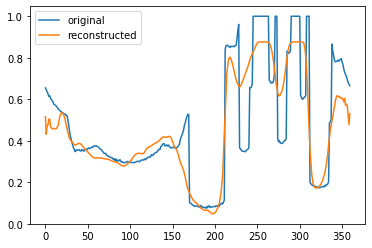

Epoch [6/100], Step [50/400], Loss: 0.022182
Epoch [6/100], Step [100/400], Loss: 0.022353
Epoch [6/100], Step [150/400], Loss: 0.020409
Epoch [6/100], Step [200/400], Loss: 0.021936
Epoch [6/100], Step [250/400], Loss: 0.021598
Epoch [6/100], Step [300/400], Loss: 0.021224
Epoch [6/100], Step [350/400], Loss: 0.021539
Epoch [6/100], Step [400/400], Loss: 0.022110
Epoch [6/100], Average Train Loss: 0.021570, Average Test Loss: 0.021339
Epoch [7/100], Step [50/400], Loss: 0.021148
Epoch [7/100], Step [100/400], Loss: 0.020863
Epoch [7/100], Step [150/400], Loss: 0.021146
Epoch [7/100], Step [200/400], Loss: 0.019728
Epoch [7/100], Step [250/400], Loss: 0.019647
Epoch [7/100], Step [300/400], Loss: 0.020599
Epoch [7/100], Step [350/400], Loss: 0.019099
Epoch [7/100], Step [400/400], Loss: 0.019853
Epoch [7/100], Average Train Loss: 0.020311, Average Test Loss: 0.020059
Epoch [8/100], Step [50/400], Loss: 0.019896
Epoch [8/100], Step [100/400], Loss: 0.019412
Epoch [8/100], Step [150/400]

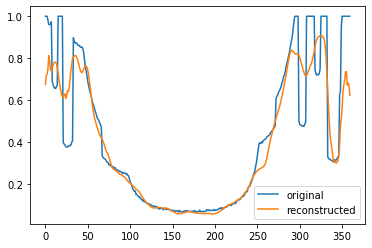

Epoch [11/100], Step [50/400], Loss: 0.017608
Epoch [11/100], Step [100/400], Loss: 0.016810
Epoch [11/100], Step [150/400], Loss: 0.016973
Epoch [11/100], Step [200/400], Loss: 0.015993
Epoch [11/100], Step [250/400], Loss: 0.016343
Epoch [11/100], Step [300/400], Loss: 0.016304
Epoch [11/100], Step [350/400], Loss: 0.016655
Epoch [11/100], Step [400/400], Loss: 0.016301
Epoch [11/100], Average Train Loss: 0.016966, Average Test Loss: 0.016792
Epoch [12/100], Step [50/400], Loss: 0.016276
Epoch [12/100], Step [100/400], Loss: 0.016663
Epoch [12/100], Step [150/400], Loss: 0.016518
Epoch [12/100], Step [200/400], Loss: 0.016707
Epoch [12/100], Step [250/400], Loss: 0.016317
Epoch [12/100], Step [300/400], Loss: 0.016045
Epoch [12/100], Step [350/400], Loss: 0.015944
Epoch [12/100], Step [400/400], Loss: 0.015417
Epoch [12/100], Average Train Loss: 0.016285, Average Test Loss: 0.016028
Epoch [13/100], Step [50/400], Loss: 0.016248
Epoch [13/100], Step [100/400], Loss: 0.015620
Epoch [13

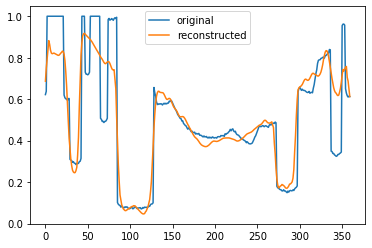

Epoch [16/100], Step [50/400], Loss: 0.014682
Epoch [16/100], Step [100/400], Loss: 0.014773
Epoch [16/100], Step [150/400], Loss: 0.014272
Epoch [16/100], Step [200/400], Loss: 0.014745
Epoch [16/100], Step [250/400], Loss: 0.013790
Epoch [16/100], Step [300/400], Loss: 0.014585
Epoch [16/100], Step [350/400], Loss: 0.013954
Epoch [16/100], Step [400/400], Loss: 0.014417
Epoch [16/100], Average Train Loss: 0.014529, Average Test Loss: 0.014482
Epoch [17/100], Step [50/400], Loss: 0.014037
Epoch [17/100], Step [100/400], Loss: 0.015366
Epoch [17/100], Step [150/400], Loss: 0.014006
Epoch [17/100], Step [200/400], Loss: 0.014068
Epoch [17/100], Step [250/400], Loss: 0.013829
Epoch [17/100], Step [300/400], Loss: 0.014084
Epoch [17/100], Step [350/400], Loss: 0.014351
Epoch [17/100], Step [400/400], Loss: 0.014835
Epoch [17/100], Average Train Loss: 0.014225, Average Test Loss: 0.014425
Epoch [18/100], Step [50/400], Loss: 0.014016
Epoch [18/100], Step [100/400], Loss: 0.014604
Epoch [18

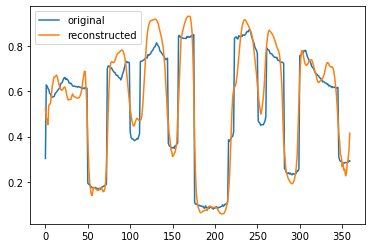

Epoch [21/100], Step [50/400], Loss: 0.013368
Epoch [21/100], Step [100/400], Loss: 0.013711
Epoch [21/100], Step [150/400], Loss: 0.013548
Epoch [21/100], Step [200/400], Loss: 0.012671
Epoch [21/100], Step [250/400], Loss: 0.013379
Epoch [21/100], Step [300/400], Loss: 0.012860
Epoch [21/100], Step [350/400], Loss: 0.013041
Epoch [21/100], Step [400/400], Loss: 0.013146
Epoch [21/100], Average Train Loss: 0.013190, Average Test Loss: 0.013127
Epoch [22/100], Step [50/400], Loss: 0.013351
Epoch [22/100], Step [100/400], Loss: 0.012999
Epoch [22/100], Step [150/400], Loss: 0.012777
Epoch [22/100], Step [200/400], Loss: 0.012739
Epoch [22/100], Step [250/400], Loss: 0.012197
Epoch [22/100], Step [300/400], Loss: 0.012625
Epoch [22/100], Step [350/400], Loss: 0.012500
Epoch [22/100], Step [400/400], Loss: 0.013096
Epoch [22/100], Average Train Loss: 0.013001, Average Test Loss: 0.013073
Epoch [23/100], Step [50/400], Loss: 0.013917
Epoch [23/100], Step [100/400], Loss: 0.012815
Epoch [23

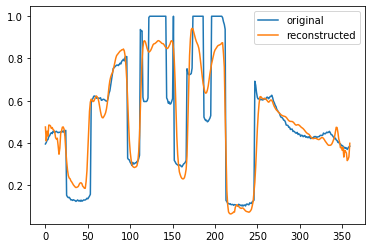

Epoch [26/100], Step [50/400], Loss: 0.012329
Epoch [26/100], Step [100/400], Loss: 0.011707
Epoch [26/100], Step [150/400], Loss: 0.011881
Epoch [26/100], Step [200/400], Loss: 0.012475
Epoch [26/100], Step [250/400], Loss: 0.012292
Epoch [26/100], Step [300/400], Loss: 0.012289
Epoch [26/100], Step [350/400], Loss: 0.011990
Epoch [26/100], Step [400/400], Loss: 0.011745
Epoch [26/100], Average Train Loss: 0.012312, Average Test Loss: 0.012335
Epoch [27/100], Step [50/400], Loss: 0.011909
Epoch [27/100], Step [100/400], Loss: 0.012111
Epoch [27/100], Step [150/400], Loss: 0.012033
Epoch [27/100], Step [200/400], Loss: 0.012727
Epoch [27/100], Step [250/400], Loss: 0.012728
Epoch [27/100], Step [300/400], Loss: 0.011860
Epoch [27/100], Step [350/400], Loss: 0.012234
Epoch [27/100], Step [400/400], Loss: 0.012309
Epoch [27/100], Average Train Loss: 0.012189, Average Test Loss: 0.012329
Epoch [28/100], Step [50/400], Loss: 0.011705
Epoch [28/100], Step [100/400], Loss: 0.011969
Epoch [28

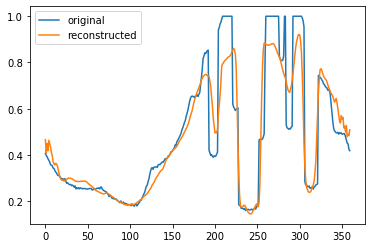

Epoch [31/100], Step [50/400], Loss: 0.011765
Epoch [31/100], Step [100/400], Loss: 0.011866
Epoch [31/100], Step [150/400], Loss: 0.011729
Epoch [31/100], Step [200/400], Loss: 0.011360
Epoch [31/100], Step [250/400], Loss: 0.011721
Epoch [31/100], Step [300/400], Loss: 0.011302
Epoch [31/100], Step [350/400], Loss: 0.012003
Epoch [31/100], Step [400/400], Loss: 0.011551
Epoch [31/100], Average Train Loss: 0.011708, Average Test Loss: 0.011872
Epoch [32/100], Step [50/400], Loss: 0.011922
Epoch [32/100], Step [100/400], Loss: 0.011460
Epoch [32/100], Step [150/400], Loss: 0.011475
Epoch [32/100], Step [200/400], Loss: 0.012341
Epoch [32/100], Step [250/400], Loss: 0.012077
Epoch [32/100], Step [300/400], Loss: 0.011159
Epoch [32/100], Step [350/400], Loss: 0.011450
Epoch [32/100], Step [400/400], Loss: 0.011020
Epoch [32/100], Average Train Loss: 0.011562, Average Test Loss: 0.011644
Epoch [33/100], Step [50/400], Loss: 0.011994
Epoch [33/100], Step [100/400], Loss: 0.011371
Epoch [33

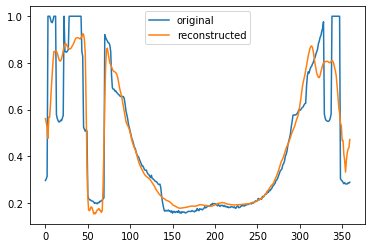

Epoch [36/100], Step [50/400], Loss: 0.011333
Epoch [36/100], Step [100/400], Loss: 0.010931
Epoch [36/100], Step [150/400], Loss: 0.011109
Epoch [36/100], Step [200/400], Loss: 0.011585
Epoch [36/100], Step [250/400], Loss: 0.011408
Epoch [36/100], Step [300/400], Loss: 0.011269
Epoch [36/100], Step [350/400], Loss: 0.011178
Epoch [36/100], Step [400/400], Loss: 0.011227
Epoch [36/100], Average Train Loss: 0.011180, Average Test Loss: 0.011214
Epoch [37/100], Step [50/400], Loss: 0.010903
Epoch [37/100], Step [100/400], Loss: 0.011143
Epoch [37/100], Step [150/400], Loss: 0.011051
Epoch [37/100], Step [200/400], Loss: 0.011569
Epoch [37/100], Step [250/400], Loss: 0.010985
Epoch [37/100], Step [300/400], Loss: 0.011246
Epoch [37/100], Step [350/400], Loss: 0.011513
Epoch [37/100], Step [400/400], Loss: 0.011091
Epoch [37/100], Average Train Loss: 0.011078, Average Test Loss: 0.011086
Epoch [38/100], Step [50/400], Loss: 0.011281
Epoch [38/100], Step [100/400], Loss: 0.010222
Epoch [38

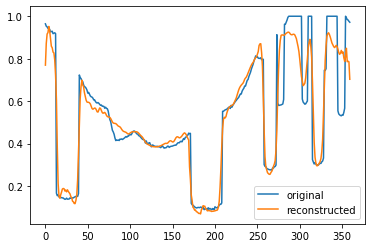

Epoch [41/100], Step [50/400], Loss: 0.011191
Epoch [41/100], Step [100/400], Loss: 0.011223
Epoch [41/100], Step [150/400], Loss: 0.010674
Epoch [41/100], Step [200/400], Loss: 0.010165
Epoch [41/100], Step [250/400], Loss: 0.011416
Epoch [41/100], Step [300/400], Loss: 0.010947
Epoch [41/100], Step [350/400], Loss: 0.010852
Epoch [41/100], Step [400/400], Loss: 0.010523
Epoch [41/100], Average Train Loss: 0.010773, Average Test Loss: 0.010905
Epoch [42/100], Step [50/400], Loss: 0.010985
Epoch [42/100], Step [100/400], Loss: 0.010604
Epoch [42/100], Step [150/400], Loss: 0.011138
Epoch [42/100], Step [200/400], Loss: 0.010209
Epoch [42/100], Step [250/400], Loss: 0.010834
Epoch [42/100], Step [300/400], Loss: 0.010589
Epoch [42/100], Step [350/400], Loss: 0.010493
Epoch [42/100], Step [400/400], Loss: 0.010968
Epoch [42/100], Average Train Loss: 0.010683, Average Test Loss: 0.010730
Epoch [43/100], Step [50/400], Loss: 0.010757
Epoch [43/100], Step [100/400], Loss: 0.010605
Epoch [43

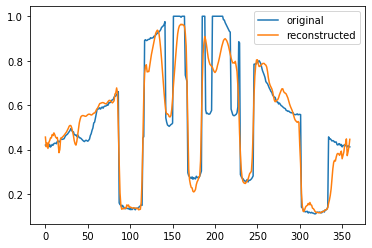

Epoch [46/100], Step [50/400], Loss: 0.010496
Epoch [46/100], Step [100/400], Loss: 0.010718
Epoch [46/100], Step [150/400], Loss: 0.010531
Epoch [46/100], Step [200/400], Loss: 0.011406
Epoch [46/100], Step [250/400], Loss: 0.010920
Epoch [46/100], Step [300/400], Loss: 0.011094
Epoch [46/100], Step [350/400], Loss: 0.010261
Epoch [46/100], Step [400/400], Loss: 0.010023
Epoch [46/100], Average Train Loss: 0.010471, Average Test Loss: 0.010399
Epoch [47/100], Step [50/400], Loss: 0.010101
Epoch [47/100], Step [100/400], Loss: 0.010627
Epoch [47/100], Step [150/400], Loss: 0.010235
Epoch [47/100], Step [200/400], Loss: 0.010957
Epoch [47/100], Step [250/400], Loss: 0.010146
Epoch [47/100], Step [300/400], Loss: 0.010537
Epoch [47/100], Step [350/400], Loss: 0.010437
Epoch [47/100], Step [400/400], Loss: 0.010199
Epoch [47/100], Average Train Loss: 0.010391, Average Test Loss: 0.010391
Epoch [48/100], Step [50/400], Loss: 0.010612
Epoch [48/100], Step [100/400], Loss: 0.010543
Epoch [48

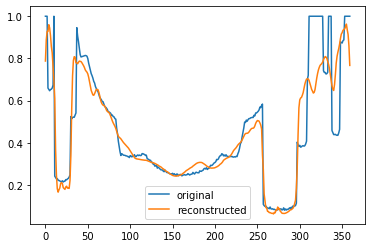

Epoch [51/100], Step [50/400], Loss: 0.010001
Epoch [51/100], Step [100/400], Loss: 0.010231
Epoch [51/100], Step [150/400], Loss: 0.010374
Epoch [51/100], Step [200/400], Loss: 0.010197
Epoch [51/100], Step [250/400], Loss: 0.010324
Epoch [51/100], Step [300/400], Loss: 0.010289
Epoch [51/100], Step [350/400], Loss: 0.010040
Epoch [51/100], Step [400/400], Loss: 0.010218
Epoch [51/100], Average Train Loss: 0.010163, Average Test Loss: 0.010176
Epoch [52/100], Step [50/400], Loss: 0.009569
Epoch [52/100], Step [100/400], Loss: 0.010560
Epoch [52/100], Step [150/400], Loss: 0.009960
Epoch [52/100], Step [200/400], Loss: 0.010166
Epoch [52/100], Step [250/400], Loss: 0.010713
Epoch [52/100], Step [300/400], Loss: 0.009979
Epoch [52/100], Step [350/400], Loss: 0.011059
Epoch [52/100], Step [400/400], Loss: 0.010251
Epoch [52/100], Average Train Loss: 0.010131, Average Test Loss: 0.010167
Epoch [53/100], Step [50/400], Loss: 0.010090
Epoch [53/100], Step [100/400], Loss: 0.010736
Epoch [53

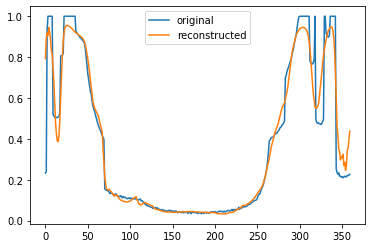

Epoch [56/100], Step [50/400], Loss: 0.009533
Epoch [56/100], Step [100/400], Loss: 0.009593
Epoch [56/100], Step [150/400], Loss: 0.009783
Epoch [56/100], Step [200/400], Loss: 0.009942
Epoch [56/100], Step [250/400], Loss: 0.010138
Epoch [56/100], Step [300/400], Loss: 0.009541
Epoch [56/100], Step [350/400], Loss: 0.010216
Epoch [56/100], Step [400/400], Loss: 0.009797
Epoch [56/100], Average Train Loss: 0.009943, Average Test Loss: 0.009992
Epoch [57/100], Step [50/400], Loss: 0.009856
Epoch [57/100], Step [100/400], Loss: 0.009627
Epoch [57/100], Step [150/400], Loss: 0.009658
Epoch [57/100], Step [200/400], Loss: 0.009441
Epoch [57/100], Step [250/400], Loss: 0.009896
Epoch [57/100], Step [300/400], Loss: 0.009540
Epoch [57/100], Step [350/400], Loss: 0.009967
Epoch [57/100], Step [400/400], Loss: 0.010460
Epoch [57/100], Average Train Loss: 0.009916, Average Test Loss: 0.010049
Epoch [58/100], Step [50/400], Loss: 0.009918
Epoch [58/100], Step [100/400], Loss: 0.010187
Epoch [58

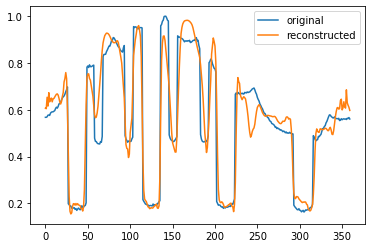

Epoch [61/100], Step [50/400], Loss: 0.010038
Epoch [61/100], Step [100/400], Loss: 0.009769
Epoch [61/100], Step [150/400], Loss: 0.009565
Epoch [61/100], Step [200/400], Loss: 0.009577
Epoch [61/100], Step [250/400], Loss: 0.009770
Epoch [61/100], Step [300/400], Loss: 0.009370
Epoch [61/100], Step [350/400], Loss: 0.010058
Epoch [61/100], Step [400/400], Loss: 0.010294
Epoch [61/100], Average Train Loss: 0.009762, Average Test Loss: 0.009766
Epoch [62/100], Step [50/400], Loss: 0.009758
Epoch [62/100], Step [100/400], Loss: 0.009635
Epoch [62/100], Step [150/400], Loss: 0.010153
Epoch [62/100], Step [200/400], Loss: 0.009662
Epoch [62/100], Step [250/400], Loss: 0.009529
Epoch [62/100], Step [300/400], Loss: 0.009607
Epoch [62/100], Step [350/400], Loss: 0.010214
Epoch [62/100], Step [400/400], Loss: 0.009996
Epoch [62/100], Average Train Loss: 0.009727, Average Test Loss: 0.009855
Epoch [63/100], Step [50/400], Loss: 0.009528
Epoch [63/100], Step [100/400], Loss: 0.009921
Epoch [63

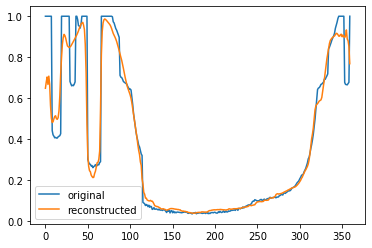

Epoch [66/100], Step [50/400], Loss: 0.010170
Epoch [66/100], Step [100/400], Loss: 0.009850
Epoch [66/100], Step [150/400], Loss: 0.009520
Epoch [66/100], Step [200/400], Loss: 0.009686
Epoch [66/100], Step [250/400], Loss: 0.009466
Epoch [66/100], Step [300/400], Loss: 0.009456
Epoch [66/100], Step [350/400], Loss: 0.009800
Epoch [66/100], Step [400/400], Loss: 0.009633
Epoch [66/100], Average Train Loss: 0.009584, Average Test Loss: 0.009728
Epoch [67/100], Step [50/400], Loss: 0.010085
Epoch [67/100], Step [100/400], Loss: 0.009630
Epoch [67/100], Step [150/400], Loss: 0.009972
Epoch [67/100], Step [200/400], Loss: 0.009772
Epoch [67/100], Step [250/400], Loss: 0.009672
Epoch [67/100], Step [300/400], Loss: 0.009581
Epoch [67/100], Step [350/400], Loss: 0.009599
Epoch [67/100], Step [400/400], Loss: 0.009988
Epoch [67/100], Average Train Loss: 0.009602, Average Test Loss: 0.009628
Epoch [68/100], Step [50/400], Loss: 0.009987
Epoch [68/100], Step [100/400], Loss: 0.009739
Epoch [68

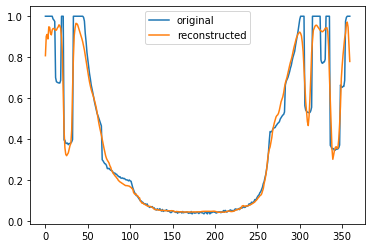

Epoch [71/100], Step [50/400], Loss: 0.009270
Epoch [71/100], Step [100/400], Loss: 0.009802
Epoch [71/100], Step [150/400], Loss: 0.009668
Epoch [71/100], Step [200/400], Loss: 0.009651
Epoch [71/100], Step [250/400], Loss: 0.009352
Epoch [71/100], Step [300/400], Loss: 0.009941
Epoch [71/100], Step [350/400], Loss: 0.009474
Epoch [71/100], Step [400/400], Loss: 0.009839
Epoch [71/100], Average Train Loss: 0.009493, Average Test Loss: 0.009492
Epoch [72/100], Step [50/400], Loss: 0.009346
Epoch [72/100], Step [100/400], Loss: 0.009679
Epoch [72/100], Step [150/400], Loss: 0.009702
Epoch [72/100], Step [200/400], Loss: 0.009857
Epoch [72/100], Step [250/400], Loss: 0.009224
Epoch [72/100], Step [300/400], Loss: 0.009509
Epoch [72/100], Step [350/400], Loss: 0.009216
Epoch [72/100], Step [400/400], Loss: 0.009387
Epoch [72/100], Average Train Loss: 0.009445, Average Test Loss: 0.009443
Epoch [73/100], Step [50/400], Loss: 0.009326
Epoch [73/100], Step [100/400], Loss: 0.009511
Epoch [73

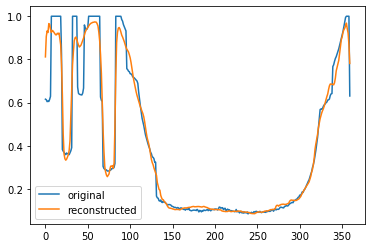

Epoch [76/100], Step [50/400], Loss: 0.009107
Epoch [76/100], Step [100/400], Loss: 0.009349
Epoch [76/100], Step [150/400], Loss: 0.009526
Epoch [76/100], Step [200/400], Loss: 0.009336
Epoch [76/100], Step [250/400], Loss: 0.009472
Epoch [76/100], Step [300/400], Loss: 0.008936
Epoch [76/100], Step [350/400], Loss: 0.009350
Epoch [76/100], Step [400/400], Loss: 0.009755
Epoch [76/100], Average Train Loss: 0.009350, Average Test Loss: 0.009634
Epoch [77/100], Step [50/400], Loss: 0.009168
Epoch [77/100], Step [100/400], Loss: 0.009971
Epoch [77/100], Step [150/400], Loss: 0.009270
Epoch [77/100], Step [200/400], Loss: 0.009033
Epoch [77/100], Step [250/400], Loss: 0.009377
Epoch [77/100], Step [300/400], Loss: 0.009314
Epoch [77/100], Step [350/400], Loss: 0.009505
Epoch [77/100], Step [400/400], Loss: 0.008868
Epoch [77/100], Average Train Loss: 0.009335, Average Test Loss: 0.009278
Epoch [78/100], Step [50/400], Loss: 0.009274
Epoch [78/100], Step [100/400], Loss: 0.008868
Epoch [78

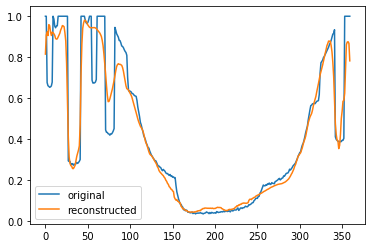

Epoch [81/100], Step [50/400], Loss: 0.009011
Epoch [81/100], Step [100/400], Loss: 0.009424
Epoch [81/100], Step [150/400], Loss: 0.009350
Epoch [81/100], Step [200/400], Loss: 0.009275
Epoch [81/100], Step [250/400], Loss: 0.009836
Epoch [81/100], Step [300/400], Loss: 0.009653
Epoch [81/100], Step [350/400], Loss: 0.008981
Epoch [81/100], Step [400/400], Loss: 0.009126
Epoch [81/100], Average Train Loss: 0.009220, Average Test Loss: 0.009409
Epoch [82/100], Step [50/400], Loss: 0.009363
Epoch [82/100], Step [100/400], Loss: 0.009570
Epoch [82/100], Step [150/400], Loss: 0.009787
Epoch [82/100], Step [200/400], Loss: 0.009055
Epoch [82/100], Step [250/400], Loss: 0.009367
Epoch [82/100], Step [300/400], Loss: 0.009470
Epoch [82/100], Step [350/400], Loss: 0.009077
Epoch [82/100], Step [400/400], Loss: 0.009126
Epoch [82/100], Average Train Loss: 0.009235, Average Test Loss: 0.009400
Epoch [83/100], Step [50/400], Loss: 0.009056
Epoch [83/100], Step [100/400], Loss: 0.009220
Epoch [83

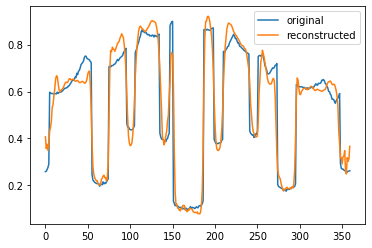

Epoch [86/100], Step [50/400], Loss: 0.009217
Epoch [86/100], Step [100/400], Loss: 0.009309
Epoch [86/100], Step [150/400], Loss: 0.009030
Epoch [86/100], Step [200/400], Loss: 0.008989
Epoch [86/100], Step [250/400], Loss: 0.009120
Epoch [86/100], Step [300/400], Loss: 0.008879
Epoch [86/100], Step [350/400], Loss: 0.008607
Epoch [86/100], Step [400/400], Loss: 0.009330
Epoch [86/100], Average Train Loss: 0.009127, Average Test Loss: 0.009120
Epoch [87/100], Step [50/400], Loss: 0.009338
Epoch [87/100], Step [100/400], Loss: 0.008770
Epoch [87/100], Step [150/400], Loss: 0.008751
Epoch [87/100], Step [200/400], Loss: 0.008659
Epoch [87/100], Step [250/400], Loss: 0.009029
Epoch [87/100], Step [300/400], Loss: 0.009621
Epoch [87/100], Step [350/400], Loss: 0.009133
Epoch [87/100], Step [400/400], Loss: 0.009346
Epoch [87/100], Average Train Loss: 0.009113, Average Test Loss: 0.009130
Epoch [88/100], Step [50/400], Loss: 0.009264
Epoch [88/100], Step [100/400], Loss: 0.009278
Epoch [88

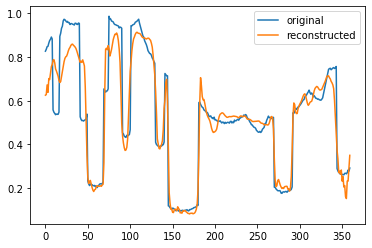

Epoch [91/100], Step [50/400], Loss: 0.009090
Epoch [91/100], Step [100/400], Loss: 0.009069
Epoch [91/100], Step [150/400], Loss: 0.008632
Epoch [91/100], Step [200/400], Loss: 0.009022
Epoch [91/100], Step [250/400], Loss: 0.009095
Epoch [91/100], Step [300/400], Loss: 0.008564
Epoch [91/100], Step [350/400], Loss: 0.009004
Epoch [91/100], Step [400/400], Loss: 0.008475
Epoch [91/100], Average Train Loss: 0.009051, Average Test Loss: 0.008955
Epoch [92/100], Step [50/400], Loss: 0.009151
Epoch [92/100], Step [100/400], Loss: 0.009194
Epoch [92/100], Step [150/400], Loss: 0.008944
Epoch [92/100], Step [200/400], Loss: 0.008683
Epoch [92/100], Step [250/400], Loss: 0.009103
Epoch [92/100], Step [300/400], Loss: 0.009229
Epoch [92/100], Step [350/400], Loss: 0.008767
Epoch [92/100], Step [400/400], Loss: 0.008969
Epoch [92/100], Average Train Loss: 0.009033, Average Test Loss: 0.008968
Epoch [93/100], Step [50/400], Loss: 0.008712
Epoch [93/100], Step [100/400], Loss: 0.009272
Epoch [93

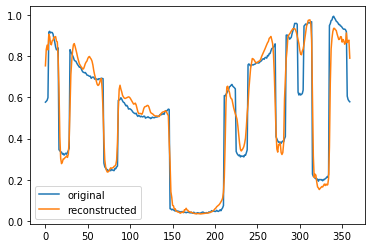

Epoch [96/100], Step [50/400], Loss: 0.008752
Epoch [96/100], Step [100/400], Loss: 0.008823
Epoch [96/100], Step [150/400], Loss: 0.008811
Epoch [96/100], Step [200/400], Loss: 0.008968
Epoch [96/100], Step [250/400], Loss: 0.009377
Epoch [96/100], Step [300/400], Loss: 0.009103
Epoch [96/100], Step [350/400], Loss: 0.008787
Epoch [96/100], Step [400/400], Loss: 0.009069
Epoch [96/100], Average Train Loss: 0.008983, Average Test Loss: 0.008977
Epoch [97/100], Step [50/400], Loss: 0.008679
Epoch [97/100], Step [100/400], Loss: 0.008947
Epoch [97/100], Step [150/400], Loss: 0.008391
Epoch [97/100], Step [200/400], Loss: 0.009130
Epoch [97/100], Step [250/400], Loss: 0.009049
Epoch [97/100], Step [300/400], Loss: 0.008848
Epoch [97/100], Step [350/400], Loss: 0.008965
Epoch [97/100], Step [400/400], Loss: 0.009127
Epoch [97/100], Average Train Loss: 0.008953, Average Test Loss: 0.008855
Epoch [98/100], Step [50/400], Loss: 0.008561
Epoch [98/100], Step [100/400], Loss: 0.008696
Epoch [98

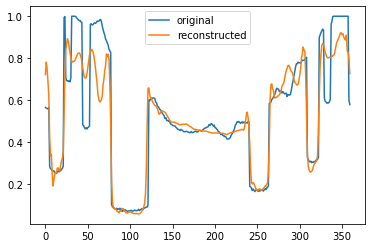

In [9]:
num_epochs = 100

for epoch in range(num_epochs):
    train_total_loss = 0.
    test_total_loss = 0.
    for i, [img] in enumerate(train_data_loader):
        outputs = autoencoder(img)
        loss = cirterion(outputs, img)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_total_loss += loss.item()
        if (i + 1) % 50 == 0:
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_data_loader)}], Loss: {loss.item():.6f}")
    with torch.no_grad():
        for [img] in test_data_loader:
          outputs = autoencoder(img)
          loss = cirterion(outputs, img)
          test_total_loss += loss.item()

    print(f"Epoch [{epoch + 1}/{num_epochs}]"
            f", Average Train Loss: {train_total_loss / len(train_data_loader):.6f}"
            f", Average Test Loss: {test_total_loss / len(test_data_loader):.6f}")
    if (epoch + 1) % 5 == 0:
        plot_result(autoencoder, test_data)

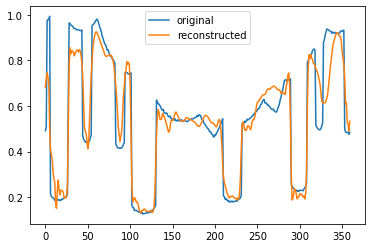

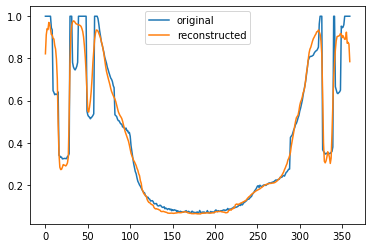

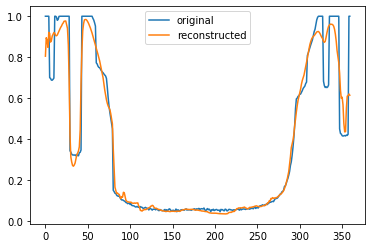

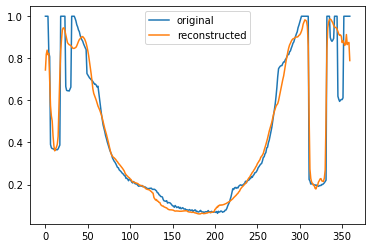

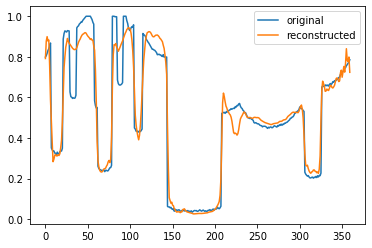

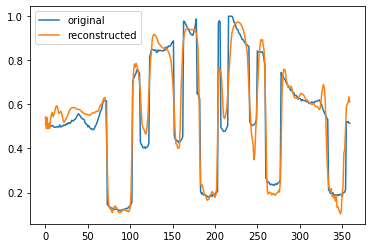

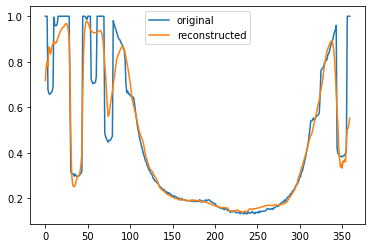

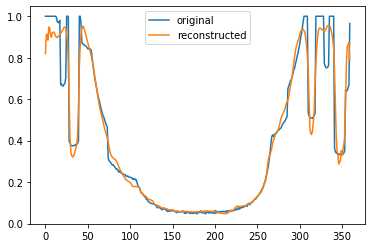

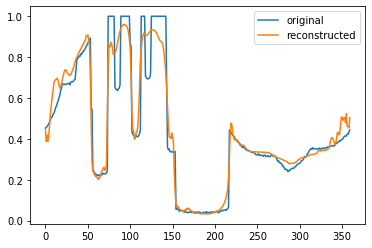

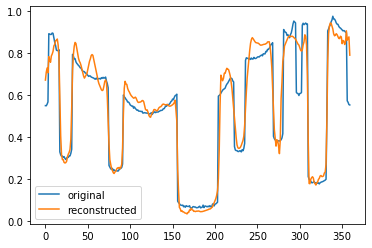

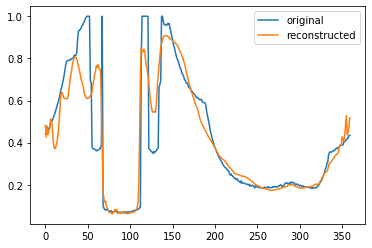

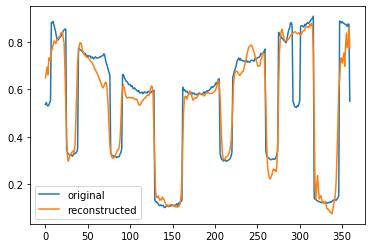

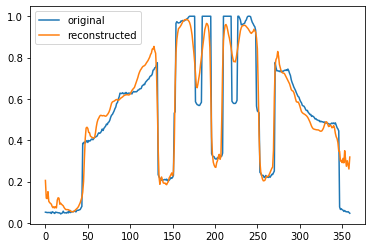

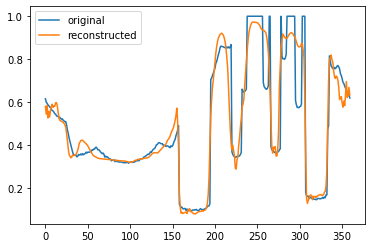

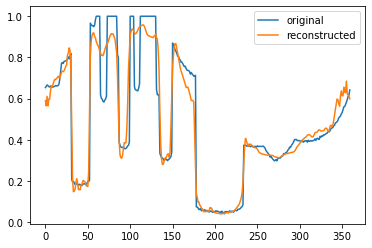

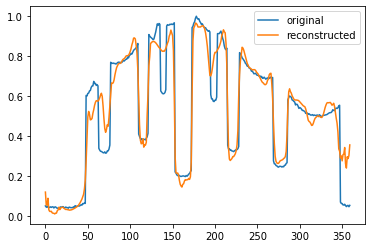

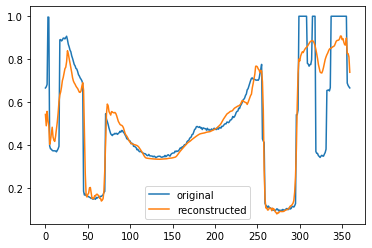

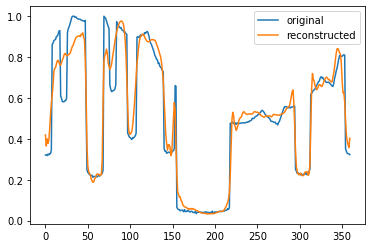

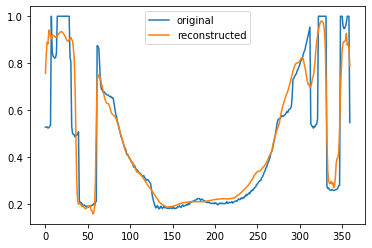

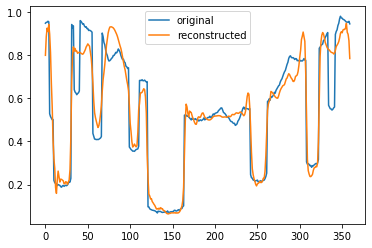

In [10]:
for _ in range(20):
    plot_result(autoencoder, test_data)

In [11]:
# TODO move const
weight_dir = "/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/"

In [12]:
torch.save(autoencoder.state_dict(), weight_dir + "scan_autoencoder_weight " + str(datetime.datetime.now())[:19])

In [13]:
weight_path = weight_dir + sorted([w for w in os.listdir(weight_dir) if "scan_autoencoder" in w])[-1]
weight_path

'/home/asad/catkin_ws2/src/turtlebot3_activeSLAM/dqn_controller/weights/scan_autoencoder_weight 2023-07-29 00:21:09'

In [14]:
model = scanAutoencoder.Autoencoder()
model.load_state_dict(torch.load(weight_path))
model = model.to(device)

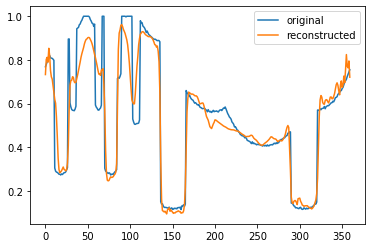

In [15]:
plot_result(model, test_data)